In [39]:
from typing import TypedDict
from langgraph.prebuilt import ToolNode, tools_condition
from typing_extensions import Annotated
from langgraph.graph import StateGraph, START, END, add_messages
import langchain_google_genai
from dotenv import load_dotenv

In [40]:
from dotenv import find_dotenv
load_dotenv()

True

In [41]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [65]:
from langchain_core.tools import tool
from langchain.chat_models import init_chat_model

@tool
def get_Stock_price(Symbol: str) -> float:
    """Return the current stock price for a given stock symbol.
    :param Symbol: Stock symbol
    :return: Current stock price
    """
    stock_prices = {
        "AAPL": 150.25,
        "GOOGL": 2800,
        "MSFT": 300
    }
    return stock_prices.get(Symbol, 0.0)


tools = [get_Stock_price]
llm = init_chat_model("google_genai:gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)

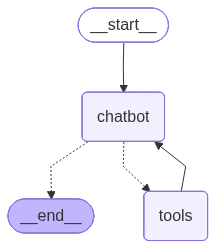

In [76]:
from langgraph.graph import StateGraph, START, END, add_messages
from typing import TypedDict, Annotated

def chatbot(state:State) -> State:
    return {
        "messages": [llm_with_tools.invoke(state["messages"])]
    }

builder = StateGraph(State)
builder.add_node(chatbot)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"chatbot")
builder.add_conditional_edges("chatbot",tools_condition)
builder.add_edge("tools","chatbot")
builder.add_edge("chatbot",END)
graph = builder.compile()
from IPython.display import display,Image
display(Image(graph.get_graph().draw_mermaid_png()))


In [80]:
response = graph.invoke({
    "messages":[
        {"role":"user","content":"what is price of apple right now? add it with price of MFST and tell me the total amount."}
    ]
})
response["messages"]

[HumanMessage(content='what is price of apple right now? add it with price of MFST and tell me the total amount.', additional_kwargs={}, response_metadata={}, id='60f04060-b8fd-410c-bfb8-0ccaa93b7c3d'),
 AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_Stock_price', 'arguments': '{"Symbol": "MSFT"}'}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019c139a-dabe-78f3-a269-4baa17e2ca3b-0', tool_calls=[{'name': 'get_Stock_price', 'args': {'Symbol': 'AAPL'}, 'id': '855372e2-e816-48bf-a997-4f69f911b1f9', 'type': 'tool_call'}, {'name': 'get_Stock_price', 'args': {'Symbol': 'MSFT'}, 'id': 'd23a29d5-2e73-4f2c-832d-843656550ed5', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 58, 'output_tokens': 15, 'total_tokens': 73, 'input_token_details': {'cache_read': 0}}),
 ToolMessage(content='150.25', name='get_Stock_price', id='100cca28-0182-44e1-a0